In [ ]:
# Chargement du dataset LFW pour Face Verification

#ETAPE 1 : Importation des bibliothèques

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_pairs

In [ ]:
#ETAPE 2 : Chargement des paires d'entraînement
# Ici on utilise la version "funneled" (alignée), en couleur, redimensionnée à 50%
lfw_pairs = fetch_lfw_pairs(subset='train', color=True, resize=0.5, funneled=True)

In [ ]:
#ETAPE 3 : Exploration de la structure du dataset 
print("Nombre total de paires :", len(lfw_pairs.pairs))
print("Forme d'une paire d'images :", lfw_pairs.pairs[0].shape)
print("Labels (0 = personnes différentes, 1 = même personne) :", np.unique(lfw_pairs.target))

Nombre total de paires : 2200
Forme d'une paire d'images : (2, 62, 47, 3)
Labels (0 = personnes différentes, 1 = même personne) : [0 1]


In [ ]:
#ETAPE 4 : Visualisation d’une paire
def plot_face_pair(index):
    img1, img2 = lfw_pairs.pairs[index]
    label = lfw_pairs.target[index]
    
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title("Image 1")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.title("Image 2")

    plt.suptitle("Même personne" if label == 1 else "Personnes différentes", fontsize=14)
    plt.show()

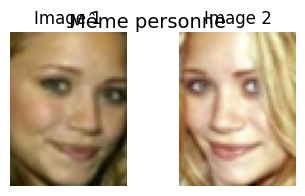

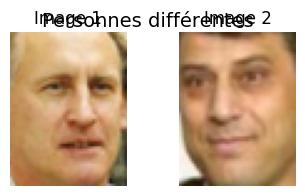

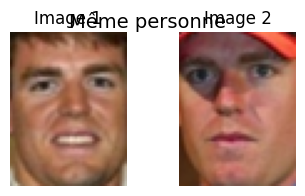

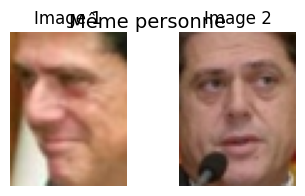

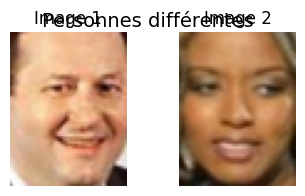

In [8]:
# Afficher 5 exemples aléatoires
for i in np.random.choice(len(lfw_pairs.pairs), 5, replace=False):
    plot_face_pair(i)

In [ ]:
#ETAPE 5 : Calcul des embeddings avec Facenet
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
import torch
import numpy as np
from sklearn.datasets import fetch_lfw_pairs
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Charger dataset LFW Pairs (train subset)
lfw_pairs = fetch_lfw_pairs(subset='train', color=True, resize=0.5, funneled=True)

# Transformations : resize, to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Charger modèle Facenet pré-entraîné
model = InceptionResnetV1(pretrained='vggface2').eval()

@torch.no_grad()
def get_embedding(img_np):
    # S'assurer que c'est bien uint8
    if img_np.dtype != np.uint8:
        img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
    
    # Gestion forme : si grayscale -> RGB
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    elif img_np.shape[2] == 1:
        img_np = np.repeat(img_np, 3, axis=2)

    # Convertir en PIL Image RGB
    img_pil = Image.fromarray(img_np).convert("RGB")

    # Appliquer transform et ajouter batch
    img_tensor = transform(img_pil).unsqueeze(0)  # shape (1,3,160,160)

    # Calcul embedding
    embedding = model(img_tensor)[0].cpu().numpy()
    return embedding

# Exemple avec la première paire
img1, img2 = lfw_pairs.pairs[0]

embedding1 = get_embedding(img1)
embedding2 = get_embedding(img2)

distance = np.linalg.norm(embedding1 - embedding2)
print("Distance euclidienne :", distance)


Distance euclidienne : 0.48132542


In [ ]:
#ETAPE 6 : Extraction des distances pour toutes les paires
from tqdm import tqdm # barre de progression
import numpy as np

# Étapes de mesure
distances = []   # distances entre embeddings
labels = []      # 1 si même personne, 0 sinon

# Boucle sur toutes les paires du dataset
for (img1, img2), label in tqdm(zip(lfw_pairs.pairs, lfw_pairs.target), total=len(lfw_pairs.pairs)):
    # 1. Obtenir les embeddings
    emb1 = get_embedding(img1)
    emb2 = get_embedding(img2)
    # 2. Calculer la distance euclidienne
    dist = np.linalg.norm(emb1 - emb2)
    # 3. Stocker la distance et le label
    distances.append(dist)
    labels.append(label)

# Conversion en tableaux numpy pour étapes suivantes
distances = np.array(distances)
labels = np.array(labels)

# Vérification
print("Nombre total de paires :", len(distances))
print("Exemples de distances :", distances[:5])
print("Exemples de labels :", labels[:5])


100%|██████████| 2200/2200 [08:52<00:00,  4.13it/s]

Nombre total de paires : 2200
Exemples de distances : [0.48132542 0.75625646 0.77625185 0.37017494 0.6406104 ]
Exemples de labels : [1 1 1 1 1]


 Meilleur seuil trouvé : 1.1111
 Précision maximale : 0.9859


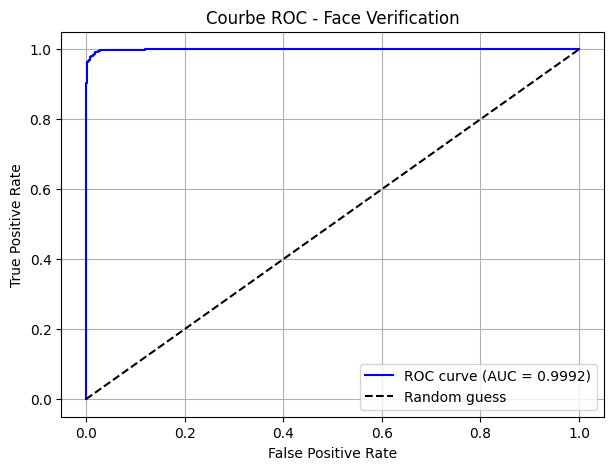

In [5]:
#ETAPE 7: Évaluation de la performance
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# étape 1: Définir une plage de seuils possibles (distance entre 0 et 2)
thresholds = np.linspace(0, 2, 100)# 1000 valeurs entre 0 et 2
accuracies = []
# étape 2 : Pour chaque seuil, prédire 1 si distance < seuil, sinon 0
for threshold in thresholds:
    preds = (distances < threshold).astype(int)  # distances vient de l'étape précédente
    acc = accuracy_score(labels, preds)
    accuracies.append(acc)
# étape 3 : Trouver le seuil avec la meilleure précision
best_index = np.argmax(accuracies)
best_threshold = thresholds[best_index]
best_accuracy = accuracies[best_index]

print(f" Meilleur seuil trouvé : {best_threshold:.4f}")
print(f" Précision maximale : {best_accuracy:.4f}")

# étape 4 : Tracer la courbe ROC et calculer l’AUC
fpr, tpr, roc_thresholds = roc_curve(labels, -distances)  # distances inversées car plus petite = positive
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Face Verification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [8]:
#ETAPE 8 : Évaluation finale avec le seuil optimal
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Remettre les labels vrais
y_true = lfw_pairs.target  # Labels réels : 0 (différents), 1 (même personne)

# 1. Appliquer le seuil pour prédire les classes
y_pred = (distances < best_threshold).astype(int)  # 1 si distance < seuil (même personne), sinon 0

# 2. Calculer la précision globale
accuracy = accuracy_score(y_true, y_pred)
print(f" Exactitude (accuracy) : {accuracy:.4f}")

# 3. Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print("\n Matrice de confusion :")
print(cm)

# 4. Rapport détaillé : précision, rappel, F1
report = classification_report(y_true, y_pred, target_names=["Différentes", "Mêmes"])
print("\n Rapport de classification :")
print(report)


 Exactitude (accuracy) : 0.9859

 Matrice de confusion :
[[1080   20]
 [  11 1089]]

 Rapport de classification :
              precision    recall  f1-score   support

 Différentes       0.99      0.98      0.99      1100
       Mêmes       0.98      0.99      0.99      1100

    accuracy                           0.99      2200
   macro avg       0.99      0.99      0.99      2200
weighted avg       0.99      0.99      0.99      2200



# ETAPE DE VISUALISATION T-SNE 
- On extrait 1 seul embedding par image (ex : le premier visage de chaque paire).

- On applique t-SNE pour projeter ces embeddings 512D → 2D.

- On utilise matplotlib pour colorer les points selon les labels :

    1 (même personne) → bleu

    0 (personnes différentes) → rougE

Extraction des embeddings pour t-SNE...


100%|██████████| 2200/2200 [04:20<00:00,  8.43it/s]


Application de t-SNE...


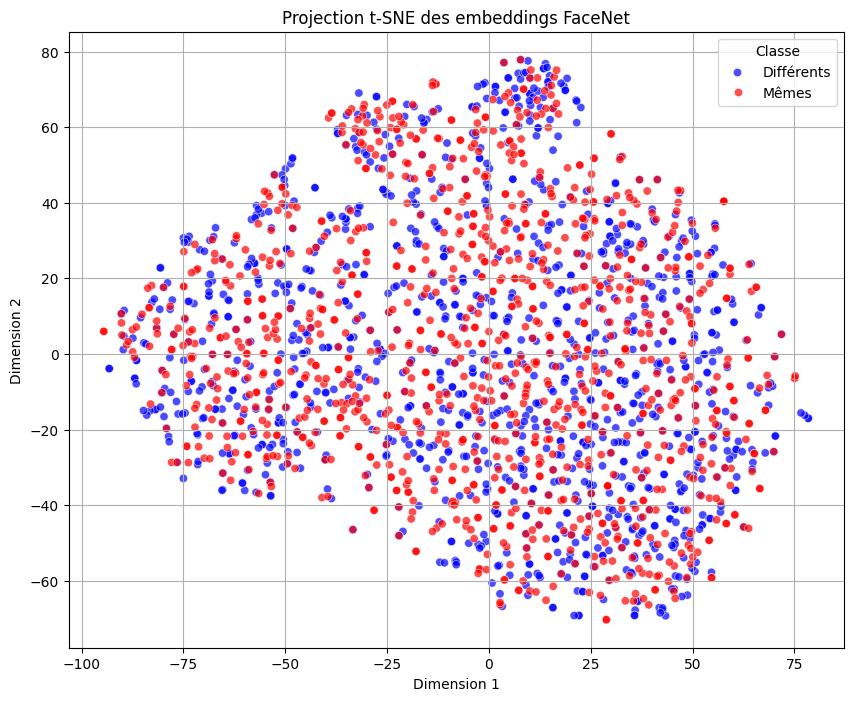

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 : Extraire les embeddings (une seule image par paire, img1)
embeddings_tsne = []
labels_tsne = []

print("Extraction des embeddings pour t-SNE...")

for i in tqdm(range(len(lfw_pairs.pairs))):
    img1, img2 = lfw_pairs.pairs[i]
    label = lfw_pairs.target[i]

    emb = get_embedding(img1)  # On prend seulement le premier visage de chaque paire
    embeddings_tsne.append(emb)
    labels_tsne.append(label)

embeddings_tsne = np.array(embeddings_tsne)
labels_tsne = np.array(labels_tsne)

# Étape 2 : Réduction de dimension avec t-SNE
print("Application de t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate='auto', init='pca', random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_tsne)

# Étape 3 : Affichage avec Seaborn/Matplotlib
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=labels_tsne,
    palette=["red", "blue"],
    alpha=0.7
)
plt.title("Projection t-SNE des embeddings FaceNet")
plt.legend(title="Classe", labels=["Différents", "Mêmes"])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


# visualisation t-SNE en 3D :

Extraction des embeddings: 100%|██████████| 500/500 [00:57<00:00,  8.65it/s]


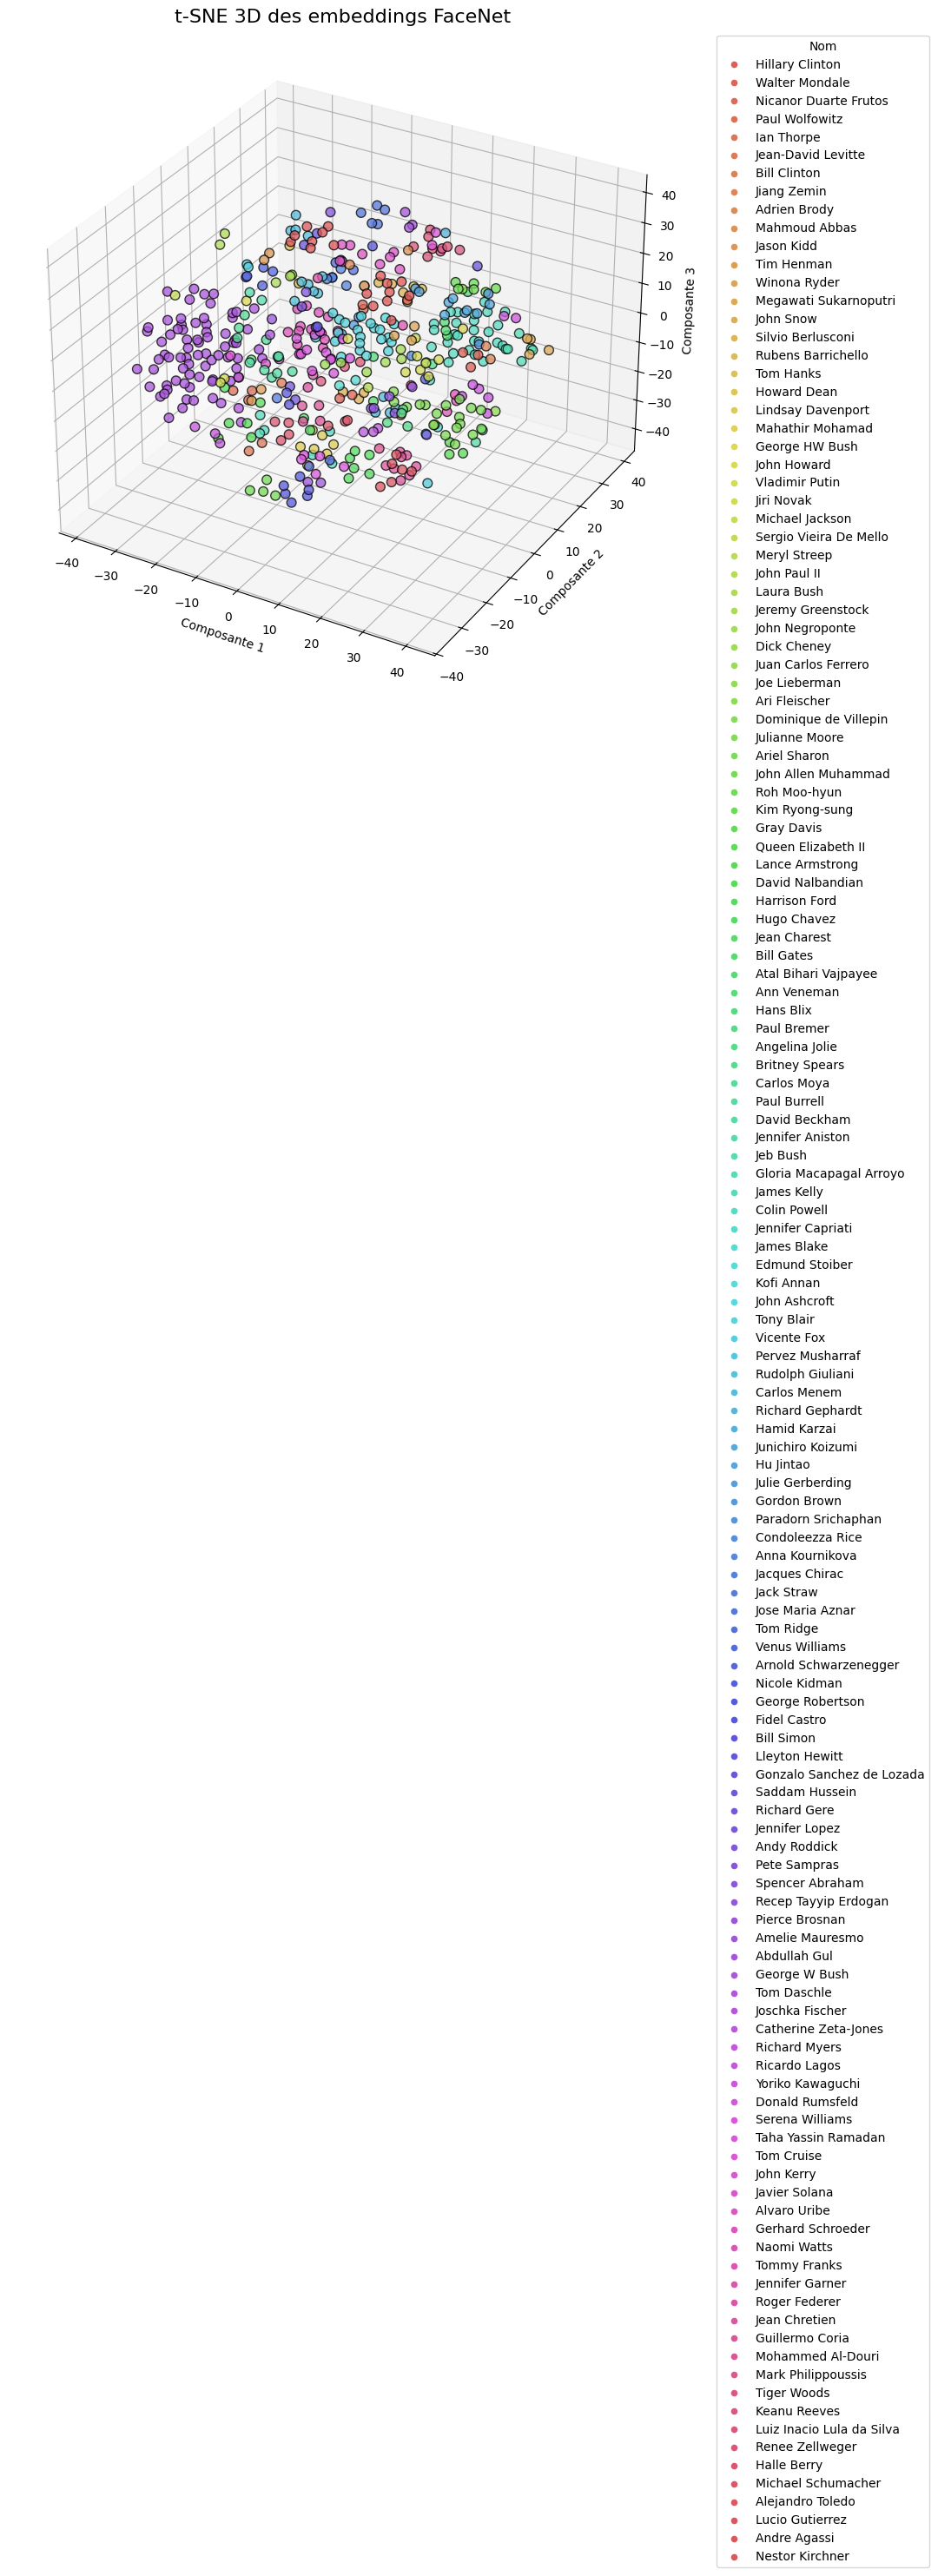

In [11]:

from sklearn.datasets import fetch_lfw_people
from sklearn.manifold import TSNE
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm

# Charger les visages LFW
lfw_people = fetch_lfw_people(color=True, resize=0.5, funneled=True, min_faces_per_person=10)

# Modèle pré-entraîné
model = InceptionResnetV1(pretrained='vggface2').eval()

# Pré-traitement des images
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

@torch.no_grad()
def get_embedding(img_np):
    if img_np.dtype != np.uint8:
        img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    elif img_np.shape[2] == 1:
        img_np = np.repeat(img_np, 3, axis=2)
    img_pil = Image.fromarray(img_np).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0)
    return model(img_tensor)[0].cpu().numpy()

# Limiter à 500 visages
n_samples = 500
images = lfw_people.images[:n_samples]
labels = lfw_people.target[:n_samples]
label_names = lfw_people.target_names
label_strs = [label_names[i] for i in labels]

# Extraire les embeddings
embeddings = []
for img in tqdm(images, desc="Extraction des embeddings"):
    embeddings.append(get_embedding(img))
embeddings = np.vstack(embeddings)

# t-SNE en 3D
tsne = TSNE(n_components=3, perplexity=30, init='pca', random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

# Palette de couleurs
unique_labels = list(set(label_strs))
palette = sns.color_palette("hls", len(unique_labels))
color_map = {name: palette[i] for i, name in enumerate(unique_labels)}
colors = [color_map[name] for name in label_strs]

# Affichage 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
           c=colors, s=60, edgecolor='k', alpha=0.75)

ax.set_title("t-SNE 3D des embeddings FaceNet", fontsize=16)
ax.set_xlabel("Composante 1")
ax.set_ylabel("Composante 2")
ax.set_zlabel("Composante 3")

# Ajout de la légende
for name in unique_labels:
    ax.scatter([], [], [], c=color_map[name], label=name)
ax.legend(title="Nom", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Tests sur le LFW test set
Objectif de l’étape "Test set" :
Charger le test set de LFW (600 paires positives, 600 négatives).
Extraire les embeddings (comme pour le train).
Calculer les distances.
Réutiliser le meilleur seuil trouvé sur le train set.
Évaluer les mêmes métriques :
    - Exactitude
    - ROC / AUC
    - Matrice de confusion
    - Rapport de classification

In [12]:
#Charger et préparer le dataset test
from sklearn.datasets import fetch_lfw_pairs

# Charger les paires du test set LFW (subset='test')
lfw_pairs_test = fetch_lfw_pairs(subset='test', color=True, resize=0.5, funneled=True)

# Afficher quelques infos pour vérifier
print("Nombre total de paires (test) :", len(lfw_pairs_test.pairs))
print("Shape d'une image exemple :", lfw_pairs_test.pairs[0][0].shape)
print("Type d'une image exemple :", type(lfw_pairs_test.pairs[0][0]))
print("Labels du test set (exemple) :", lfw_pairs_test.target[:10])


Nombre total de paires (test) : 1000
Shape d'une image exemple : (62, 47, 3)
Type d'une image exemple : <class 'numpy.ndarray'>
Labels du test set (exemple) : [1 1 1 1 1 1 1 1 1 1]


In [13]:
#Extraction des embeddings pour les paires test

import numpy as np
from tqdm import tqdm  # Pour la barre de progression

# Initialisation des tableaux pour stocker les embeddings
embeddings1 = []
embeddings2 = []

# Extraction embeddings sur toutes les paires test
for img1, img2 in tqdm(lfw_pairs_test.pairs):
    emb1 = get_embedding(img1)
    emb2 = get_embedding(img2)
    embeddings1.append(emb1)
    embeddings2.append(emb2)

# Conversion en numpy array pour la suite
embeddings1 = np.array(embeddings1)
embeddings2 = np.array(embeddings2)

print("Extraction des embeddings terminée.")
print("Shape embeddings1 :", embeddings1.shape)
print("Shape embeddings2 :", embeddings2.shape)


100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]

Extraction des embeddings terminée.
Shape embeddings1 : (1000, 512)
Shape embeddings2 : (1000, 512)


In [14]:
#Prédiction et évaluation sur le test set

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# 1. Recalculer les distances euclidiennes entre embeddings
test_distances = np.linalg.norm(embeddings1 - embeddings2, axis=1)

# 2. Appliquer le seuil optimal trouvé précédemment
test_pred = (test_distances < best_threshold).astype(int)

# 3. Récupérer les vrais labels du test set
test_labels = lfw_pairs_test.target

# 4. Évaluer les performances
test_accuracy = accuracy_score(test_labels, test_pred)
conf_mat = confusion_matrix(test_labels, test_pred)
report = classification_report(test_labels, test_pred, target_names=["Différentes", "Mêmes"])
roc_auc = roc_auc_score(test_labels, -test_distances)  # inverser car plus petite distance = plus probable

# 5. Affichage des résultats
print(f" Exactitude (accuracy) sur le test set : {test_accuracy:.4f}\n")
print("  Matrice de confusion :")
print(conf_mat)
print("\n Rapport de classification :")
print(report)
print(f" AUC (test set) : {roc_auc:.4f}")


 Exactitude (accuracy) sur le test set : 0.9760

  Matrice de confusion :
[[485  15]
 [  9 491]]

 Rapport de classification :
              precision    recall  f1-score   support

 Différentes       0.98      0.97      0.98       500
       Mêmes       0.97      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

 AUC (test set) : 0.9968
